Pau has produced MC samples of $^{214}\text{Bi}$ decays in different volumes of the detector.
<br>
We are interested in:
- How many electrons coming from the $^{214}\text{Bi}$ @ cathode end up being fiducials.
- Energy specturm of fiducial electrons induced by $^{214}\text{Bi}$
<!-- end of the list -->
This notebook has five main parts:
- A _Testing Zone_ where all the interesting cuts are inspected in detail.
- All the processing process of an entire set of MCs is applied in _Processing_. Recently we use the processing functions from low-background analysis.
- In _Selection_, we apply the Trigger2 cut and detector region tagging.
- _Plots_ is used for paper purposes.
- In _ROI Analysis_ we compute the important numbers of background index.

__IMPORTANT__: Define in _Preliminary_ all the configuration needed for the use of this notebook or the name of H5 file you will use from _Selection_.

In [ ]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis')

from libs import bckg_functions as bf
from libs import crudo
from libs import fit_functions as ff
from libs import plotting_tools as pt

from   datetime import datetime
import glob
from   invisible_cities.reco.corrections import apply_all_correction
from   invisible_cities.types.symbols    import NormStrategy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from   matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import numpy as np
import os
import pandas as Path
from   PIL import Image
import scipy

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preliminary

In [79]:
# ----- Type of Analysis ----- #
ANALYSIS_TYPE = 'Cathode'                       # Options: 'All', 'Cathode'
DATE = datetime.now().strftime('%d%m%Y')        # Current Date
# DATE = '23092025'                             # Specific Date

# Exposure
RUN_TIME_ALL     = 315360000    # Simulated exposure (10 years) in [s]
RUN_TIME_CATHODE = 315360       # Simulated exposure (0.01 year) in [s]

In [ ]:
# --------------------------------------------
# 1. MC DIRECTORIES, PATHS, KEYS AND FILENAMES
# --------------------------------------------
MC_PATHS = []
if ANALYSIS_TYPE == 'All':

    MC_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_09_00/Bi214/'
    # Get all subfolders in MC_DIR
    VOLUMES = [folder for folder in os.listdir(MC_DIR) if os.path.isdir(os.path.join(MC_DIR, folder)) and folder != 'CATHODE_SURF']
    for volume in sorted(VOLUMES):
        # Get all sophronia files in the volume subfolder
        sophronia_files = sorted(glob.glob(os.path.join(MC_DIR, volume, 'sophronia', '*.sophronia.h5')))
        # print(f"  Found {len(sophronia_files)} sophronia files in {volume}")
        if sophronia_files:
            MC_PATHS.extend(sophronia_files)
        else:
            print(f"No sophronia files found in {volume}")
    # Sort the final list of paths
    MC_PATHS = sorted(MC_PATHS)
    print(f"Total sophronia files to process: {len(MC_PATHS)}")

elif ANALYSIS_TYPE == 'Cathode':

    MC_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_09_00/Bi214/CATHODE_SURF/sophronia/'
    MC_PATHS = sorted(glob.glob(MC_DIR + '*.sophronia.h5'))
    print(f"Total sophronia files to process: {len(MC_PATHS)}")

else:
    raise ValueError("Invalid ANALYSIS_TYPE. Choose 'All' or 'Cathode'.")

# KEYS
nexus     = '/MC/configuration'
dorothea  = '/DST/Events'
sophronia = '/RECO/Events'
mc_key    = '/MC/Events'

# COLIUMNS TO USE
doro_columns = ['event', 'time', 'nS1', 'nS2', 'S1h', 'S1e', 'S2e', 'S2q', 'DT', 'X', 'Y', 'Z']
soph_columns = ['event', 'time', 'npeak', 'X', 'Xpeak', 'Y', 'Z', 'Q', 'Ec']

# OUTPUT
OUTPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/'
OUTPUT_H5  = 'processed_MC_background_' + ANALYSIS_TYPE + '_' + DATE + '.h5'
print(f"Output will be saved to: {os.path.join(OUTPUT_DIR, OUTPUT_H5)}")

# ----------------------
# 2. ANALYSIS PARAMETERS
# ----------------------
V_DRIFT = 0.865     # Drift velocity in [mm/μs]

# --- S1 Signal Cuts ---
# Po-like events are filtered using: S1h >= m * S1e + b
M_NOPOLIKE = 0.17
B_NOPOLIKE = -56

# --- S1e Correction ---
DT_STOP = 1372.2543          # Cathode temporal position in [μs]
CV_FIT  = [0.57, 796.53]     # Fit values for S1e correction vs DT

# --- Alpha/Electron Separation Cut ---
# Events with total corrected energy above this threshold are classified as alphas.
ENERGY_THRESHOLD_PE = 7.5e5       # in [PE]



# --- Trigger 2 Efficiency Cut ---
# Events with event-level energy below this are removed to account for trigger efficiency.
TRG2_THRESHOLD = 0.5         # in [MeV]

# -------------------
# 3. DETECTOR REGIONS
# -------------------
# Geometric boundaries for event classification.
Z_LOW = 40          # in [mm]
Z_UP  = 1147        # in [mm]
R_UP  = 451.65      # in [mm]

Total sophronia files to process: 5000
Output will be saved to: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/processed_MC_background_Cathode_28112025.h5


# Testing Zone

We first explore the content of the _dorothea_ and _sophronia_ dataframes.

## Reconstruction

In [8]:
# Initialize empty lists to store the dataframes
run_dst  = []
run_reco = []
doro_counter, soph_counter = 0, 0

# ----- File Loop ----- #
for h5_path in MC_PATHS[:50]:

    # print(f"--- Processing {h5_path} ---")

    try:
        # ----- Dorothea ----- #
        dst_df = pd.read_hdf(h5_path, key=dorothea)
        # dst_df = dst_df.loc[:, doro_columns]          # Activate this when you are completely sure!
        doro_counter += dst_df['event'].nunique()
        run_dst.append(dst_df)

        # ----- Sophronia ----- #
        reco_df = pd.read_hdf(h5_path, key=sophronia)
        # reco_df = reco_df.loc[:, soph_columns]
        soph_counter += reco_df['event'].nunique()
        run_reco.append(reco_df)

    except KeyError as e:
        print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

# ----- Concatenate Data ----- #
test_doro = pd.DataFrame()
test_soph = pd.DataFrame()

if run_dst:
    test_doro = pd.concat(run_dst, ignore_index=True)

if run_reco:
    test_soph = pd.concat(run_reco, ignore_index=True)

# ----- Print Summary ----- #
print(f"--- You have loaded {len(run_dst)} files ---")
print(f"Dorothea events  = {doro_counter}")
print(f"Sophronia events = {soph_counter}")

--- You have loaded 50 files ---
Dorothea events  = 2820
Sophronia events = 2780


#### Why are those numbers different?

If the $S2$ signal is not strong enough to activate the SiPMs (lower charge than the threshold), a false hit is created with negative values in $XYZ$ but the energy of the corresponding slice is stored.
<br>
__Hyp:__ Sophronia ignores pairs with _weak_ $S2$ signals.

In [18]:
print(test_doro[test_doro.event == 313].s2_peak.nunique())
test_doro[test_doro.event == 31]

3


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
53,31,6.309883e+07,65535,0,0,1,NaN,NaN,NaN,NaN,...,18,NaN,NaN,7.125937,80.543386,119.4284,144.049922,0.977454,208.131857,171.913311


In [19]:
print(test_soph[test_soph.event == 313].npeak.nunique())
test_soph[test_soph.event == 31]

3


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
37774,31,6.309883e+07,1,80.543387,119.428401,1,-65.775,106.975,0.0,0.0,11.793394,11.594203,1066.025651,-1.0,0.002579,-1,-1.0
37775,31,6.309883e+07,1,80.543387,119.428401,1,-65.775,399.425,0.0,0.0,11.793394,6.492754,596.974349,-1.0,0.001559,-1,-1.0
37776,31,6.309883e+07,1,80.543387,119.428401,1,181.025,168.175,0.0,0.0,18.624525,5.159420,5718.000000,-1.0,0.014042,-1,-1.0


In [20]:
# ----- Dorothea ----- #
weak_S2_ids = test_doro.loc[test_doro['S2q'] < 0, 'event'].unique()     # List of events with weaks S2

# ----- Sophronia ----- #
weak_S2_in_soph_ids = []

for evt_id in weak_S2_ids:

    # Dorothea
    df_doro = test_doro[test_doro['event'] == evt_id]
    nS2_doro = df_doro['s2_peak'].nunique()

    # Sophronia
    df_soph = test_soph[test_soph['event'] == evt_id]
    nS2_soph = df_soph['npeak'].nunique()

    if nS2_doro == nS2_soph:
        weak_S2_in_soph_ids.append(evt_id)
    else:
        continue

print(f"From {len(weak_S2_ids)} events with weak S2 in Dorothea, {len(weak_S2_in_soph_ids)} have the same number of S2 peaks in Sophronia.")

From 980 events with weak S2 in Dorothea, 0 have the same number of S2 peaks in Sophronia.


Most of the pairs with $S2$ weak are ignored in Sophronia.

In [21]:
hits_S2_weak = []
hits_S2_norm = []

for evt_id in weak_S2_in_soph_ids:

    print(f"--- Event {evt_id}: ---")

    # Sophronia
    df_soph_npeak = test_soph[test_soph['event'] == evt_id].groupby('npeak')

    for npeak_id, group in df_soph_npeak:

        if (group['Xpeak'] < -5000).any():  # These are the weak S2 peaks
            hits_S2_weak.append(len(group))
            print(f"  Peak {npeak_id} is weak and has {len(group)} hits.")
        else:
            hits_S2_norm.append(len(group))

In [22]:
# Global
min_hits = min(min(hits_S2_weak), min(hits_S2_norm))
max_hits = max(max(hits_S2_weak), max(hits_S2_norm))
bins = np.arange(min_hits, max_hits + 2)

# Histogram for hits_S2_weak
hits_weak_counts, hits_weak_edges = np.histogram(hits_S2_weak, bins=bins)

# Histogram for hits_S2_norm
hits_norm_counts, hits_norm_edges = np.histogram(hits_S2_norm, bins=bins)

# Plotting
plt.figure(figsize=(8, 6))
plt.stairs(hits_weak_counts, hits_weak_edges, fill=False, lw=1.5, ec='blue', label='Weak S2 Peaks')
plt.stairs(hits_norm_counts, hits_norm_edges, fill=False, lw=1.5, ec='green', label='Normal S2 Peaks')

# Styling
plt.xlabel('Number of Hits')
# plt.xlim(0, 100)
plt.ylabel('Counts')
plt.title('Hits Multiplicity per S2 Peak')
plt.legend()

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

ValueError: min() arg is an empty sequence

I will ignore all these weak $S2$ peaks.

## Cleaning Part

In [23]:
# Remove weak S2 peaks in Dorothea and Sophronia
test_doro = test_doro[test_doro['S2q'] >= 0].copy()
test_soph = test_soph[test_soph['Xpeak'] >= -5000].copy()

print(f"After removing weak S2 peaks: {test_soph['event'].nunique()} events ({test_soph['event'].nunique()/soph_counter:.2%})")

# Set hits with NaN or negative energy to 0
test_soph['Ec'] = np.where(
                                pd.notna(test_soph['Ec']) & (test_soph['Ec'] > 0),        # Condition
                                test_soph['Ec'],                                          # Value if condition is True
                                0                                                         # Value if condition is False   
)

# Update dataframes
good_evts_01 = test_soph['event'].unique()
test_doro = test_doro[test_doro['event'].isin(good_evts_01)].copy()     # Keep only events with good sophronia info

print(f"After set hits with NaN or negative energy to 0: {len(good_evts_01)} events ({len(good_evts_01)/soph_counter:.2%})")

After removing weak S2 peaks: 2780 events (100.00%)
After set hits with NaN or negative energy to 0: 2780 events (100.00%)


## $S1$ Signal

#### How does the $S1$ behave?

In [24]:
test_doro['nS1'].value_counts()

1    3515
0     412
2      18
Name: nS1, dtype: int64

I would not expect events with $0\,S1$ (anode-like), let's see some of them

In [25]:
evts_NO_S1 = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique()
print(len(evts_NO_S1))

352


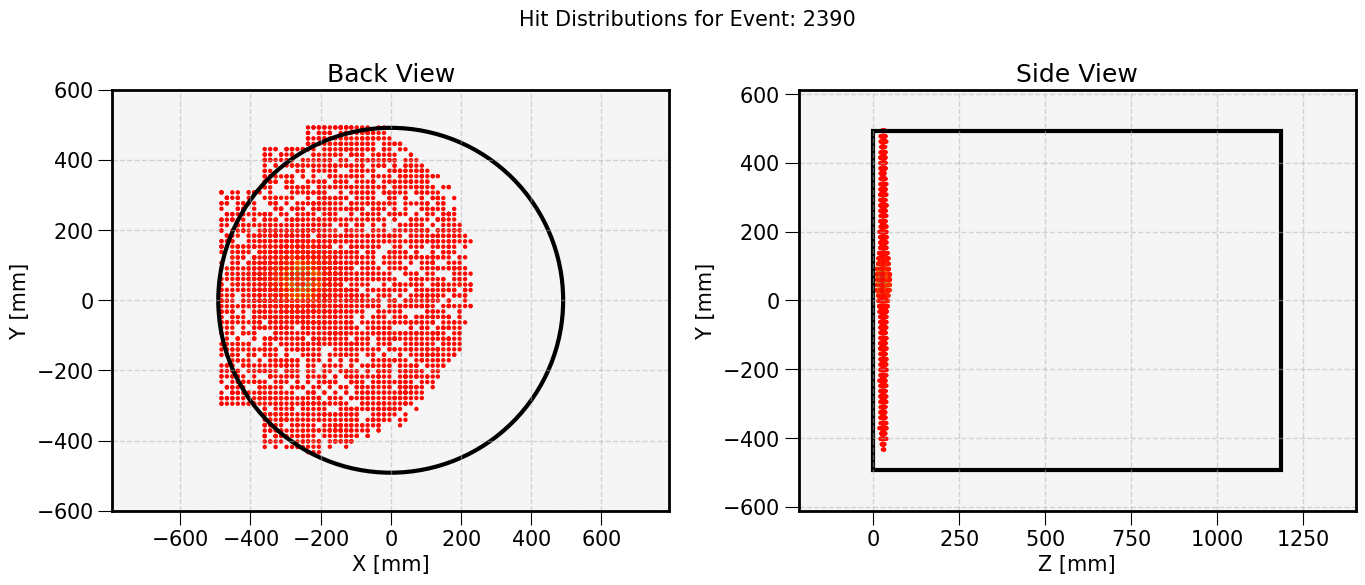

In [26]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(evts_NO_S1))

But yeah, they look like events near to the anode, in particular, coming from the edges of the detector.

In [27]:
# ----- nS1 = 1 ----- #
data_S1 = test_doro[test_doro['nS1'] == 1].copy()

# ----- nS1 = 1 & nS2 = 1 ----- #
data_S1_S2 = data_S1[data_S1['nS2'] == 1].copy()

# ----- S1e Correction ----- #
data_S1    = crudo.correct_S1e(data_S1,    CV_FIT, DT_STOP, output_column='S1e_corr')
data_S1_S2 = crudo.correct_S1e(data_S1_S2, CV_FIT, DT_STOP, output_column='S1e_corr')

Is the $S1$ energy corrected?

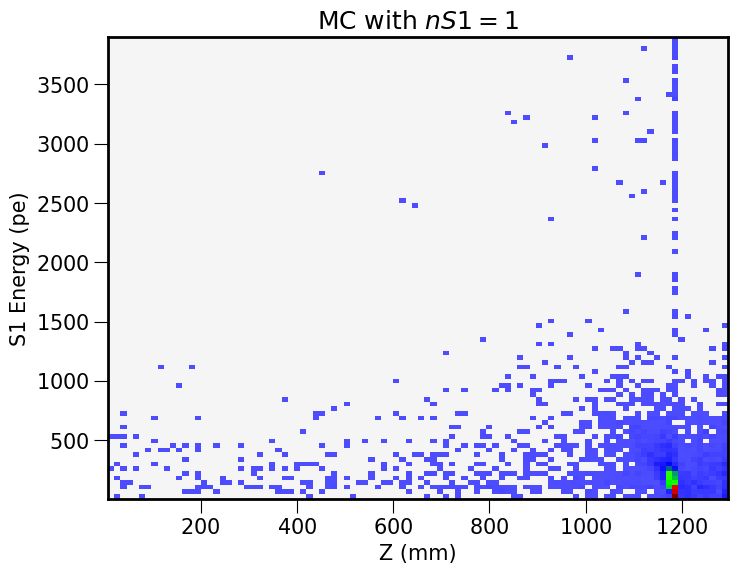

In [28]:
# Global
n_bins = 100
E1_max = 3e3; Z_max = pt.N100_hei

# Variables
E1 = data_S1['S1e']
Z  = data_S1['Z']

# Binning
E1_bins = np.linspace(E1.min(), E1.max(), n_bins)
Z_bins = np.linspace(0, Z_max, n_bins)

# 2D histogram
S1e_Z_map, ex, ey = np.histogram2d(Z, E1, bins=n_bins)
S1e_Z_map         = np.ma.masked_where(S1e_Z_map==0, S1e_Z_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1e_Z_map.T, cmap=pt.custom_hsv, shading='auto')

# ----- Styling ----- #
# cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Z (mm)')
plt.ylabel('S1 Energy (pe)')
plt.title(r'MC with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

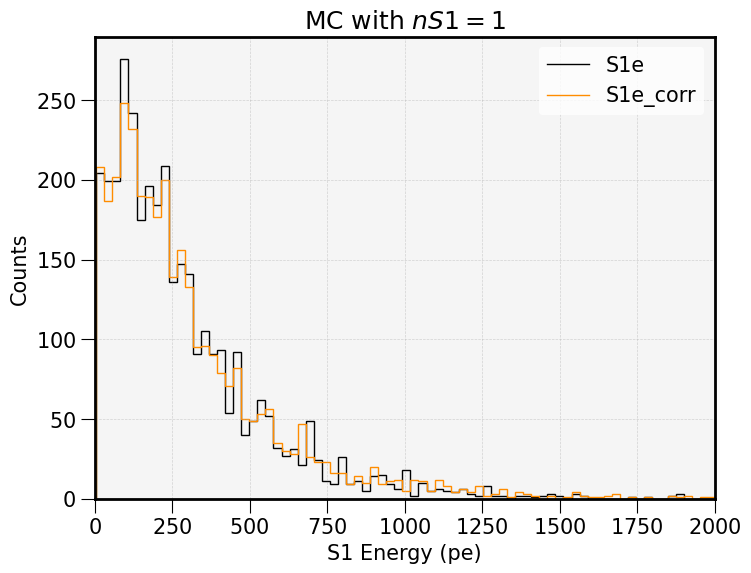

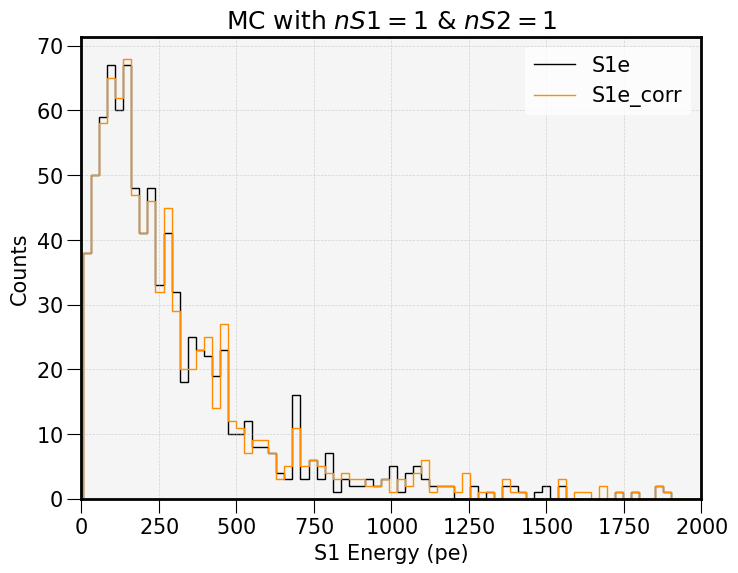

In [29]:
# Global
n_bins = 150
E1_max = 2e3
titles = [r'MC with $nS1 = 1$', r'MC with $nS1 = 1$ & $nS2 = 1$']

for i, df in enumerate([data_S1, data_S1_S2]):

    plt.figure(figsize=(8, 6))
    plt.title(titles[i])
    _, E1_edges = np.histogram(df['S1e'], bins=n_bins)

    for j, col in enumerate(['S1e', 'S1e_corr']):

        # Variables
        E1 = df[col]

        # Histogram
        E1_counts, _ = np.histogram(E1, bins=E1_edges)

        # ----- Plotting ----- #
        plt.stairs(E1_counts, E1_edges, label=f'{col}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j*2 % len(pt.hist_colors)])

    # Styling
    plt.xlabel('S1 Energy (pe)')
    plt.xlim(0, E1_max)
    plt.ylabel('Counts')
    plt.legend()

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

The $S1e$ correction is very small, given that they are mostly cathode events.

#### Is it important a NO-Polike cut?

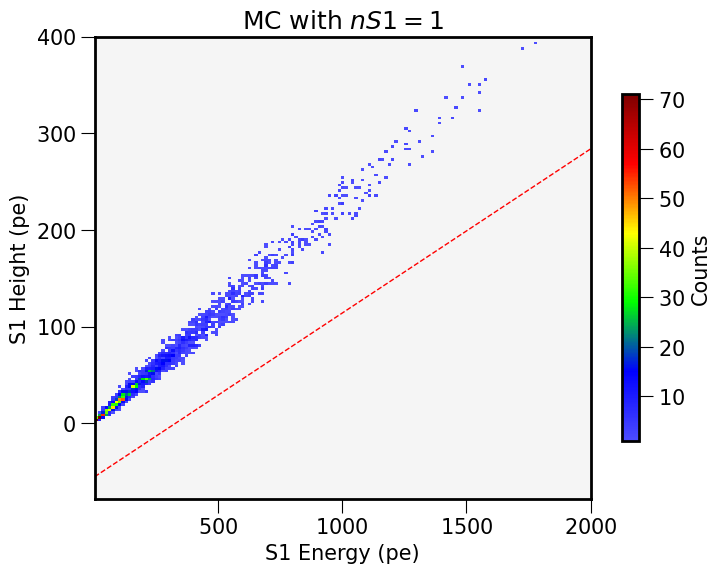

In [30]:
# Global
n_bins = 150
H1_max = 400; E1_max = 2e3

# Variables
H1 = data_S1['S1h']
E1 = data_S1['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1_max, n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, M_NOPOLIKE, B_NOPOLIKE), c='red', ls='--', lw=1)        # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('S1 Energy (pe)')
plt.ylabel('S1 Height (pe)')
plt.title(r'MC with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

Nope, it is completely unnecesary.

### Execution

In [31]:
print("After S1 signal cuts:")

# ----- Counters for Efficiencies ----- #
evt_prior = test_soph['event'].nunique()
nS1_0_evt_ids = test_doro.loc[test_doro['nS1'] == 0, 'event'].unique();   print(f"    nS1 = 0: {len(nS1_0_evt_ids)} events ({len(nS1_0_evt_ids)/evt_prior:.2%})")
nS1_1_evt_ids = test_doro.loc[test_doro['nS1'] == 1, 'event'].unique();   print(f"    nS1 = 1: {len(nS1_1_evt_ids)} events ({len(nS1_1_evt_ids)/evt_prior:.2%})")

# ----- S1 Signal ----- #
test_doro = test_doro[(test_doro['nS1'] == 0) | (test_doro['nS1'] == 1)].copy()

# ----- S1e Correction ----- #
test_doro = crudo.correct_S1e(test_doro, CV_FIT, DT_STOP, output_column='S1e_corr')    # I'll work with this corrected S1 energy
# Check if the correction was applied
if 'S1e_corr' not in test_doro.columns:
    print(f"Error: S1e correction not applied! Skipping...")

# Update dataframes
good_evts_02 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evts_02)].copy()

print(f"{len(good_evts_02)} events ({len(good_evts_02)/evt_prior:.2%})")

After S1 signal cuts:
    nS1 = 0: 352 events (12.66%)
    nS1 = 1: 2423 events (87.16%)
2775 events (99.82%)


## $S2$ Signal

#### How does it behave the $S2$ energy?

In [32]:
# ----- nS2 = 1 ----- #
data_S2 = test_doro[test_doro['nS2'] == 1].copy()

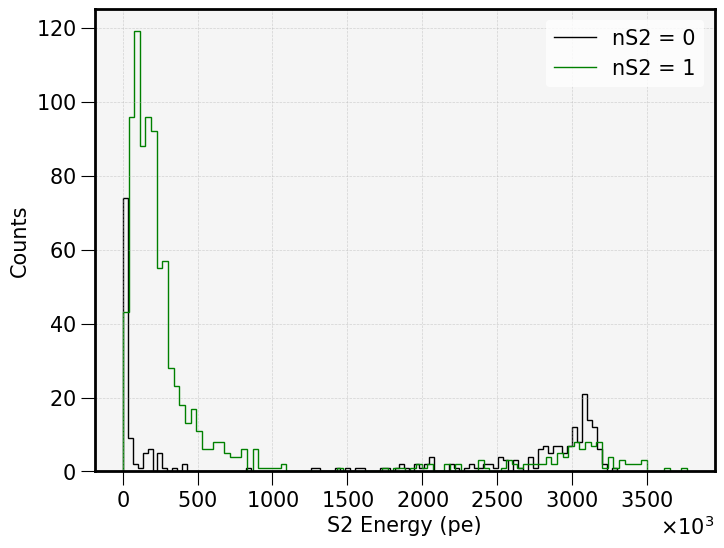

In [33]:
# Global
n_bins = 100
E2_max = 2000e3

plt.figure(figsize=(8, 6))

for i, label in enumerate(['nS2 = 0', 'nS2 = 1']):
    
    if label == 'nS2 = 0':
        data = data_S2[data_S2['nS1'] == 0].copy()
        E2 = data['S2e']
    else:
        data = data_S2[data_S2['nS1'] == 1].copy()
        E2 = data['S2e']

    # Histogram
    E2_counts, E2_edges = np.histogram(E2, bins=n_bins)

    # ----- Plotting ----- #
    plt.stairs(E2_counts, E2_edges, label=label, 
               fill=False, lw=1.0, ec=pt.hist_colors[4*i % len(pt.hist_colors)])

# Styling
plt.xlabel('S2 Energy (pe)')
# plt.xlim(0, E2_max)
plt.ylabel('Counts')
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend()

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

We know that alpha population is around $1000\times10^{3}\,\text{pe}$.
<br>
The $nS2 = 1$ cut remove almost all the aplha contribution (BiPo coincidence!).
<br>
In any case, let's check that population of events around $3000\times10^{3}\,\text{pe}$.

In [34]:
pop_3000_ids = data_S2.loc[data_S2['S2e'] >= 3000e3, 'event'].unique()
print(len(pop_3000_ids))

136


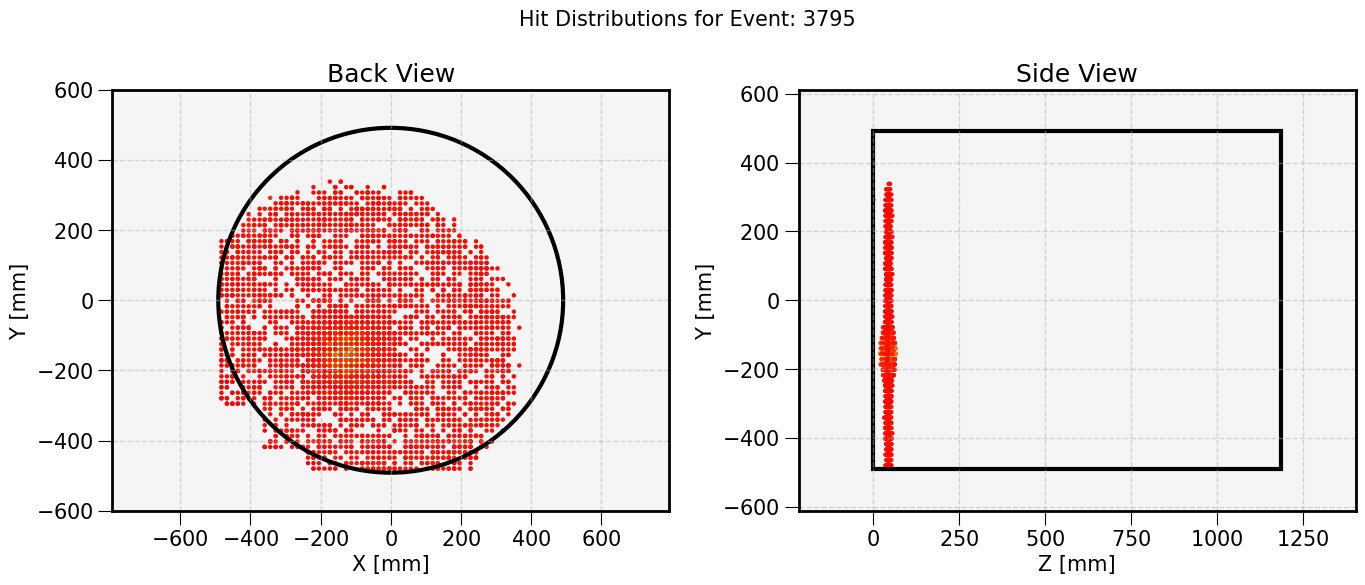

In [35]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_3000_ids))

This population seems to be alphas but with so many hits! __Why?__

In [36]:
pop_std_ids = data_S2.loc[data_S2['S2e'] < 1500e3, 'event'].unique()
print(len(pop_std_ids))

926


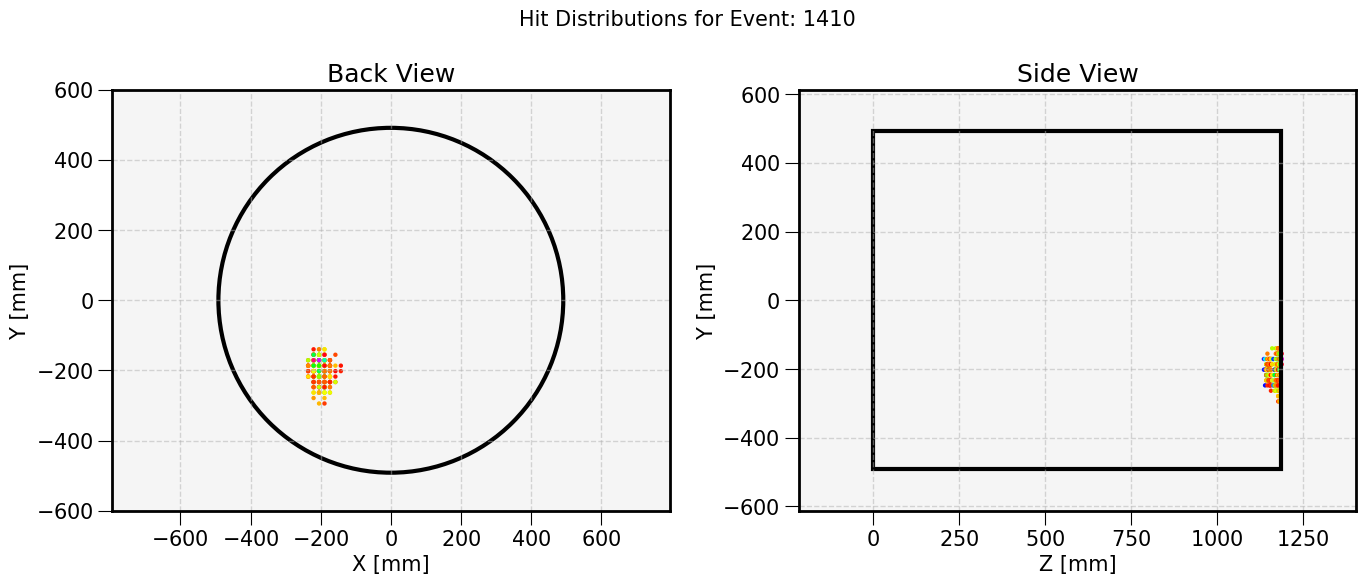

In [37]:
pt.event_display(test_soph, variable='Ec', event=np.random.choice(pop_std_ids))

Here I notice more events "well-reconstructed", but we still need to distinguish between alphas and electrons.
<br>
First, we apply the $nS2 = 1$ cut.
<br>
__Notice the low efficieny, we are killing the BiPo coincidence!__

### Execution

In [38]:
# Event counter
evt_prior = test_soph['event'].nunique()

# ----- S2 Signal ----- #
test_doro = test_doro[test_doro['nS2'] == 1].copy()

# Update dataframes
good_evt_03 = test_doro['event'].unique()
test_soph = test_soph[test_soph['event'].isin(good_evt_03)].copy()

print(f"After S2 signal cut: {len(good_evt_03)} events ({len(good_evt_03)/evt_prior:.2%})")

After S2 signal cut: 1204 events (43.39%)


## $\alpha$ and $e$ Populations

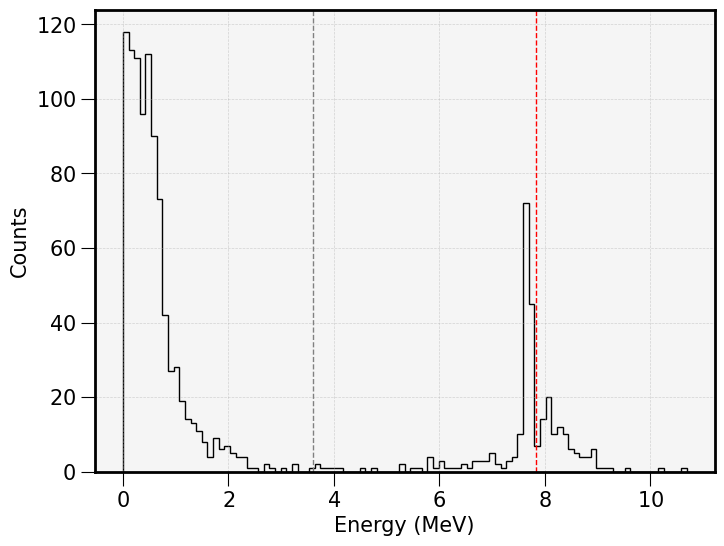

In [42]:
# Global
n_bins = 100

# Variables
E = test_soph.groupby('event')['Ec'].sum()

# Histogram
E_counts, E_edges = np.histogram(E, bins=n_bins)

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.stairs(E_counts, E_edges,
           fill=False, lw=1.0, ec='black')
    
# 214Po peak as reference!
x_Po = 7.83
plt.axvline(x=x_Po, color='red', ls='--', lw=1)
# plt.text(0.98*x_Po, 300, f'{x_Po} MeV', c='red', ha='right', va='bottom')

# Energy threshold
x_flag = ENERGY_THRESHOLD_MEV
plt.axvline(x=x_flag, color='gray', ls='--', lw=1)
# plt.text(0.98*x_flag, 300, f'{x_flag:.2f} MeV', c='gray', ha='right', va='bottom')

# ----- Styling ----- #
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
# plt.yscale('log')

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

As alphas, we expect to have them around $7.83\,\text{MeV}$ (the Q value of $^{214}\text{Po}$).
<br>
I will use the same energy threshold to separate alphas and electrons (gray line).

In [65]:
# Event counter
evt_prior = test_soph['event'].nunique()

# Variables
evt_energy = test_soph.groupby('event')['Ec'].sum()

# Event IDs for alphas and electrons
elec_ids  = evt_energy[evt_energy <= ENERGY_THRESHOLD_MEV].index
alpha_ids = evt_energy[evt_energy >  ENERGY_THRESHOLD_MEV].index

# Update dataframes
test_doro = test_doro[test_doro['event'].isin(elec_ids)].copy()
test_soph = test_soph[test_soph['event'].isin(elec_ids)].copy() 
print(f"Electron candidates: {len(elec_ids)} events ({len(elec_ids)/evt_prior:.2%}) ")

Electron candidates: 923 events (100.00%) 


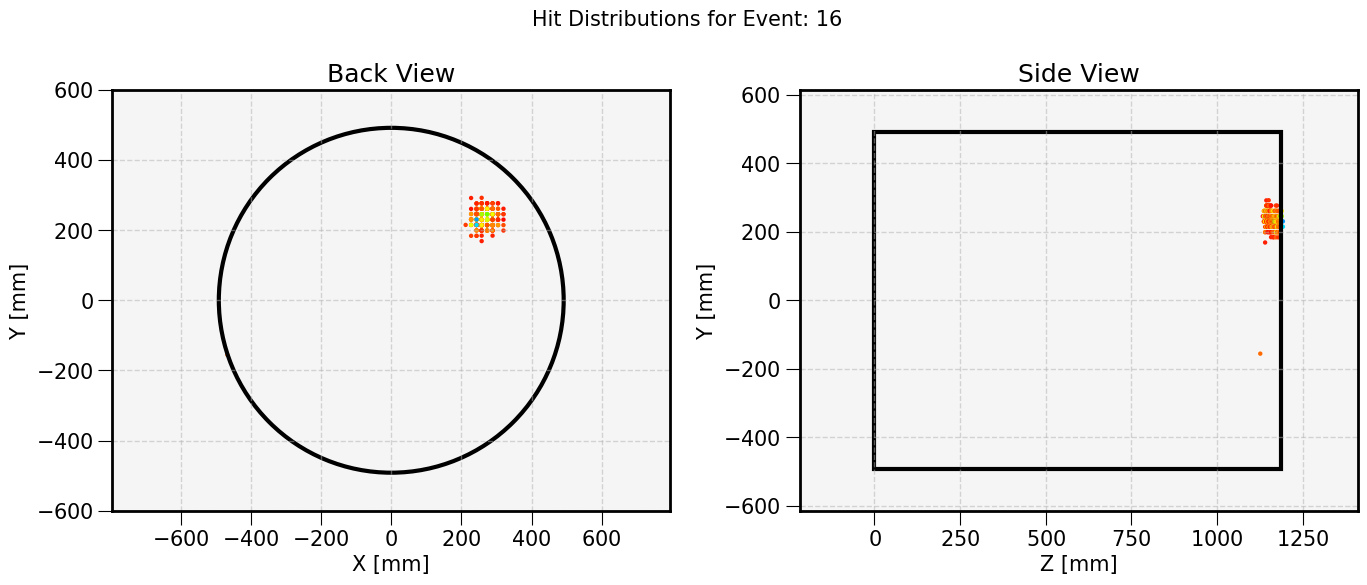

In [63]:
pt.event_display(test_soph, variable='Ec')

Max. Energy: 3.6012 MeV


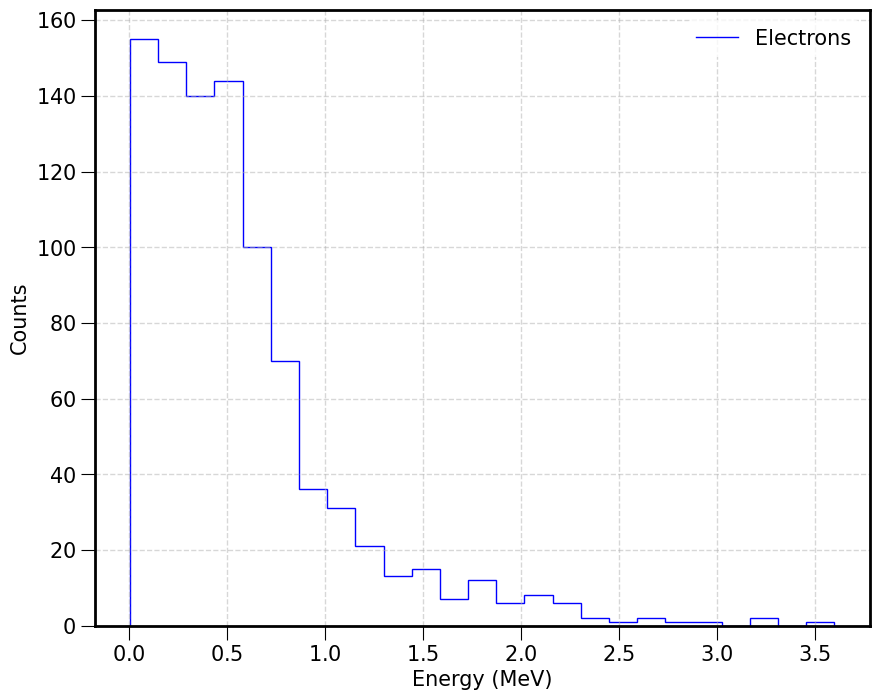

In [ ]:
E_electron_evt = test_soph.groupby('event')['Ec'].sum()
print(f'Max. Energy: {E_electron_evt.max():.4f} MeV')

# Binning
E_electron, e_elec = np.histogram(E_electron_evt, bins=25)

plt.stairs(E_electron, e_elec, fill=False, ec='blue', lw=1.0, label='Electrons')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

# Processing

In [39]:
# Event counters
Total_gen   = 0
Total_reco  = 0   
Total_clean = 0
Total_S1 = 0;      Total_nS1_one  = 0;     Total_nS1_zero  = 0
Total_S2 = 0
Total_electron = 0

# Store all the processed dfs
all_processed_dfs = []
all_sophronia_dfs = []

# ----- File Loop ----- #
for i, h5_path in enumerate(MC_PATHS):

    print(f"--- Processing {i + 1} / {len(MC_PATHS)} ---")

    # ----- Nexus ----- #
    df_nexus = pd.DataFrame()
    try:
        df_nexus = pd.read_hdf(h5_path, key=nexus)
        # Count the number of generated events
        Total_gen += int(df_nexus.loc[df_nexus['param_key'] == 'num_events', 'param_value'].values[0])
    except KeyError:
        print(f"Key {nexus} not found in {h5_path}. Skipping...")
        continue

    # ----- Dorothea ----- #
    df_dorothea = pd.DataFrame()
    try:
        df_dorothea = pd.read_hdf(h5_path, key=dorothea).loc[:, doro_columns]
    except KeyError:
        print(f"Key {dorothea} not found in {h5_path}. Skipping...")
        continue

    # ----- Sophronia ----- #
    df_sophronia = pd.DataFrame()
    try:
        df_sophronia = pd.read_hdf(h5_path, key=sophronia).loc[:, soph_columns]
        # Count the number of events after the IC reconstruction chain
        Total_reco += df_sophronia['event'].nunique()
    except KeyError:
        print(f"Key {sophronia} not found in {h5_path}. Skipping...")
        continue

    # ----- Cleaning Part ----- #
    # Remove weak S2 peaks in Dorothea and Sophronia
    df_dorothea  = df_dorothea[df_dorothea['S2q'] >= 0].copy()
    df_sophronia = df_sophronia[df_sophronia['Xpeak'] >= -5000].copy()

    # Set hits with NaN or negative energy to 0
    df_sophronia['Ec'] = np.where(
                                    pd.notna(df_sophronia['Ec']) & (df_sophronia['Ec'] > 0),        # Condition
                                    df_sophronia['Ec'],                                             # Value if condition is True
                                    0                                                               # Value if condition is False   
    )

    # Update dataframes
    evts_after_clean = df_sophronia['event'].unique()
    df_dorothea = df_dorothea[df_dorothea['event'].isin(evts_after_clean)].copy()
    Total_clean += len(evts_after_clean)

    # ----- Basic Cuts & S1e Correction ----- #
    # nS1 <= 1 (NO-Polike)
    Total_nS1_zero += df_dorothea.loc[df_dorothea['nS1'] == 0, 'event'].nunique()
    Total_nS1_one  += df_dorothea.loc[df_dorothea['nS1'] == 1, 'event'].nunique()
    s1_mask = (df_dorothea['nS1'] == 0) | (df_dorothea['nS1'] == 1)
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, cut_mask=s1_mask, df_for_mask=df_dorothea)
    Total_S1 += df_sophronia['event'].nunique()
    # nS2 = 1
    s2_mask = (df_dorothea['nS2'] == 1)
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, cut_mask=s2_mask, df_for_mask=df_dorothea)
    Total_S2 += df_sophronia['event'].nunique()
    # S1e Correction (NO mandatory)
    df_dorothea = crudo.correct_S1e(df_dorothea, CV_FIT, DT_STOP, output_column='S1e_corr')     # Based on alpha analysis

    # ----- Electron Candidates ----- #
    # Variables
    event_energy = df_sophronia.groupby('event')['Ec'].sum()
    elec_ids = event_energy[event_energy <= ENERGY_THRESHOLD_MEV].index     # Index in this group is event ID
    df_dorothea, df_sophronia = bf.apply_cut_and_update(df_dorothea, df_sophronia, event_ids=elec_ids)
    Total_electron += df_sophronia['event'].nunique()

    # ----- Final DataFrame @ Event-level ----- #
    # Dorothea aggregation
    doro_agg_dict = {
                        'nS1': ('nS1', 'max'),
                        'nS2': ('nS2', 'max'),
                        'S1e': ('S1e', 'max'),
                        'S1e_corr': ('S1e_corr', 'max'),
                    }
    doro_agg_df = df_dorothea.groupby('event', as_index=False).agg(**doro_agg_dict)
    # Sophronia aggregation: at event and npeak level
    soph_agg_dict = {
                        'time': ('time', 'mean'),
                        'X_bary': ('X', lambda x: bf.weighted_avg(x, df_sophronia.loc[x.index, 'Ec'])),
                        'Y_bary': ('Y', lambda y: bf.weighted_avg(y, df_sophronia.loc[y.index, 'Ec'])),
                        'Z_bary': ('Z', lambda z: bf.weighted_avg(z, df_sophronia.loc[z.index, 'Ec'])),
                        'E_mev': ('Ec', 'sum'),
                        'Z_min': ('Z', 'min'),
                        'Z_max': ('Z', 'max'),
                        'R_max': ('X', lambda g: bf.R_max_func(df_sophronia.loc[g.index]))
                    }
    # Perform aggregation
    df_event = df_sophronia.groupby(['event', 'npeak'], as_index=False).agg(**soph_agg_dict)
    df_event = pd.merge(df_event, doro_agg_df, on='event', how='left')

    # ----- Monte Carlo Information ----- #
    parts = h5_path.split('/')
    # Isotope
    df_sophronia['Isotope'] = parts[-4]
    df_event['Isotope']     = parts[-4]
    # Volume
    df_sophronia['Volume']  = parts[-3]
    df_event['Volume']      = parts[-3]

    # Append to the main DataFrame
    all_processed_dfs.append(df_event)
    all_sophronia_dfs.append(df_sophronia)

# ----- Concatenation ----- #
if all_processed_dfs:
    final_mc_df = pd.concat(all_processed_dfs, ignore_index=True)
else:
    print("   Warning: No data was processed. Empty output.")
    final_mc_df = pd.DataFrame()
if all_sophronia_dfs:
    final_soph_df = pd.concat(all_sophronia_dfs, ignore_index=True)
else:
    print("   Warning: No Sophronia data was processed. Empty output.")
    final_soph_df = pd.DataFrame()
    
# ----- Final Verbosity ----- #
print("\n--- Processing Summary ---")
print(f"Total generated events                = {Total_gen} ({Total_gen/Total_gen:.2%})")
print(f"Total events after reco chain         = {Total_reco} ({Total_reco/Total_gen:.2%})")
print(f"Total events after cleaning           = {Total_clean} ({Total_clean/Total_reco:.2%})")
print(f"Total events after nS1 cut            = {Total_S1} ({Total_S1/Total_clean:.2%})")
print(f"    - of which nS1 = 0 ¬ {Total_nS1_zero} ({Total_nS1_zero/Total_clean:.2%})")
print(f"    - of which nS1 = 1 ¬ {Total_nS1_one} ({Total_nS1_one/Total_clean:.2%})")
print(f"Total events after nS2 cut            = {Total_S2} ({Total_S2/Total_S1:.2%})")
print(f"Total events after electron selection = {Total_electron} ({Total_electron/Total_S2:.2%})")

print('\nY ya, eso es todo, eso es todo ♥')

--- Processing 1 / 5000 ---
--- Processing 2 / 5000 ---
--- Processing 3 / 5000 ---
--- Processing 4 / 5000 ---
--- Processing 5 / 5000 ---
--- Processing 6 / 5000 ---
--- Processing 7 / 5000 ---
--- Processing 8 / 5000 ---
--- Processing 9 / 5000 ---
--- Processing 10 / 5000 ---
--- Processing 11 / 5000 ---
--- Processing 12 / 5000 ---
--- Processing 13 / 5000 ---
--- Processing 14 / 5000 ---
--- Processing 15 / 5000 ---
--- Processing 16 / 5000 ---
--- Processing 17 / 5000 ---
--- Processing 18 / 5000 ---
--- Processing 19 / 5000 ---
--- Processing 20 / 5000 ---
--- Processing 21 / 5000 ---
--- Processing 22 / 5000 ---
--- Processing 23 / 5000 ---
--- Processing 24 / 5000 ---
--- Processing 25 / 5000 ---
--- Processing 26 / 5000 ---
--- Processing 27 / 5000 ---
--- Processing 28 / 5000 ---
--- Processing 29 / 5000 ---
--- Processing 30 / 5000 ---
--- Processing 31 / 5000 ---
--- Processing 32 / 5000 ---
--- Processing 33 / 5000 ---
--- Processing 34 / 5000 ---
--- Processing 35 / 500

We define a _global event ID_, 'cause we can have repeated _event ID_ across different isotopes and volumes
<br>
Additionally, we copy this information along isotope/volume tags into hits dataframe

In [ ]:
for dataframe in [final_soph_df, final_mc_df]:
    # An original event is defined as a row in dataframe where at least one of the columns 
    # ('event', 'Isotope', 'Volume') differs from the corresponding row below it (using `shift`).
    event_OG = (dataframe[['event', 'Isotope', 'Volume']] != dataframe[['event', 'Isotope', 'Volume']].shift())

    # If any column in event_OG is True, it means the row corresponds to the start of a new original event block.
    new_event_block = event_OG.any(axis=1)

    # Use `cumsum()` on the boolean mask to create a unique identifier for each contiguous block of hits 
    # that belong to the same original event.
    unique_block_id = new_event_block.cumsum()

    # Assign a unique global event ID to each block of original events.
    # The `factorize` function generates a unique integer code for each unique block ID.
    dataframe['global_event'] = pd.factorize(unique_block_id)[0]
    print(f"{dataframe['global_event'].nunique()} unique global events identified.")

# Counter
processed_evts = final_mc_df['global_event'].nunique()

93537 unique global events identified.
93537 unique global events identified.


## $E\,\geq\,0.5\,\text{MeV}$

In [49]:
trg2_mask = (final_mc_df['E_mev'] >= TRG2_THRESHOLD)
events_after_trg2 = final_mc_df.loc[trg2_mask, 'global_event'].unique()
print(f"For Energy ≥ {TRG2_THRESHOLD} MeV: {len(events_after_trg2)} events ({len(events_after_trg2)/processed_evts:.2%})")

# Update dataframes
final_mc_df   = final_mc_df[final_mc_df['global_event'].isin(events_after_trg2)].copy()
final_soph_df = final_soph_df[final_soph_df['global_event'].isin(events_after_trg2)].copy()

For Energy ≥ 0.5 MeV: 42639 events (45.59%)


## Detector Regions Tagging

In [ ]:
event_region_tags = bf.tag_event_by_detector_region(final_mc_df, z_cut_low=Z_LOW, z_cut_high=Z_UP, r_cut_high=R_UP, event_col='global_event')

Check some events if you want to

In [51]:
event_region_tags

global_event
2        cathode
3        cathode
5        cathode
7        cathode
10       cathode
          ...   
93526    cathode
93528    cathode
93529    cathode
93530    cathode
93531    cathode
Length: 42639, dtype: object

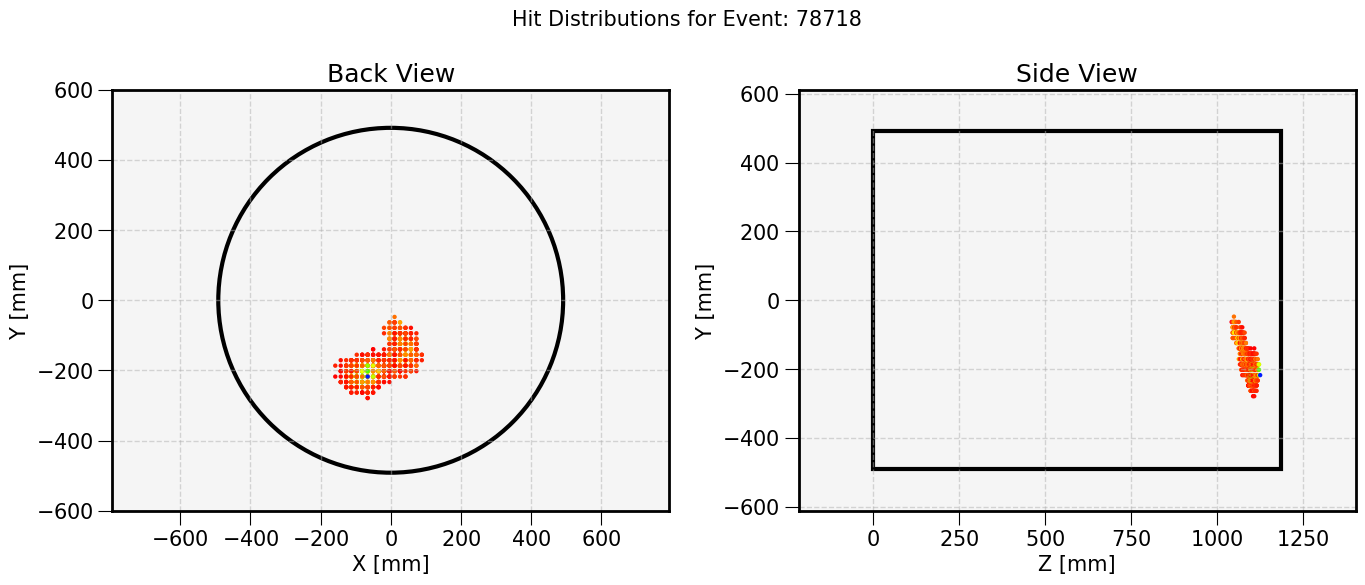

In [59]:
pt.event_display(final_soph_df, variable='Ec', event_column='global_event', event=78718)

Update dataframes and counts!

In [71]:
# Add region tags to both dataframes
final_mc_df['region'] = event_region_tags.values
final_soph_df         = final_soph_df.merge(final_mc_df[['global_event', 'region']], on='global_event', how='left')

# Event counts by particle and region
detector_region_counts = final_mc_df.groupby(['region'])['global_event'].nunique()
for region in ['fiducial', 'tube', 'cathode', 'anode']:
    reg_events = detector_region_counts.get(region, 0)
    print(f'{region.capitalize()} = {reg_events} events ({reg_events/len(events_after_trg2):.2%})')

Fiducial = 98 events (0.23%)
Tube = 174 events (0.41%)
Cathode = 39714 events (93.14%)
Anode = 2653 events (6.22%)


## Output

Let's store the final dataframe as an HDF5 file

In [74]:
# 4. OUTPUT
print("\n----- Saving output files")
# npeak column in run_event_df is uint64, convert to int64
for col in final_mc_df.select_dtypes(include=['uint64']).columns:
    final_mc_df[col] = final_mc_df[col].astype('int64')
# Combine all processed dataframes into one
output_filepath = os.path.join(OUTPUT_DIR, OUTPUT_H5)
print(f"Opening HDF5 store for writing: {output_filepath}")
try:
    with pd.HDFStore(output_filepath, mode='w') as store:
        if not final_mc_df.empty:
            store.put('Events', final_mc_df, format='table', data_columns=True)
        if not final_soph_df.empty:
            store.put('Hits', final_soph_df, format='table', data_columns=True)
    print("HDF5 saving complete.")
except Exception as e:
    print(f"   Error writing to HDF5 file: {e}", file=sys.stderr)


----- Saving output files
Opening HDF5 store for writing: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Rn_analysis/h5/processed_MC_background_Cathode_28112025.h5
HDF5 saving complete.


# Analysis

## Input

Load the dataframes @ event or hits-level, as you prefer.
<br>
__NOTE:__ Be careful with the dates!

In [ ]:
# ----- Cathode ----- #
EVENTS_CATHODE_DF = pd.read_hdf(os.path.join(OUTPUT_DIR, 'processed_MC_background_Cathode_28112025.h5'), key='Events')
HITS_CATHODE_DF   = pd.read_hdf(os.path.join(OUTPUT_DIR, 'processed_MC_background_Cathode_28112025.h5'), key='Hits')

# ----- All 214Bi Simulation ----- #

In [ ]:
EVENTS_ALL_DF = pd.read_hdf(os.path.join(OUTPUT_DIR, 'processed_MC_background_All_28112025.h5'), key='Events')

## Single-track

In [115]:
# Fiducial events
FIDUCIAL_HITS_CATHODE_DF = HIT_CATHODE_DF[HIT_CATHODE_DF['region'] == 'fiducial'].copy()

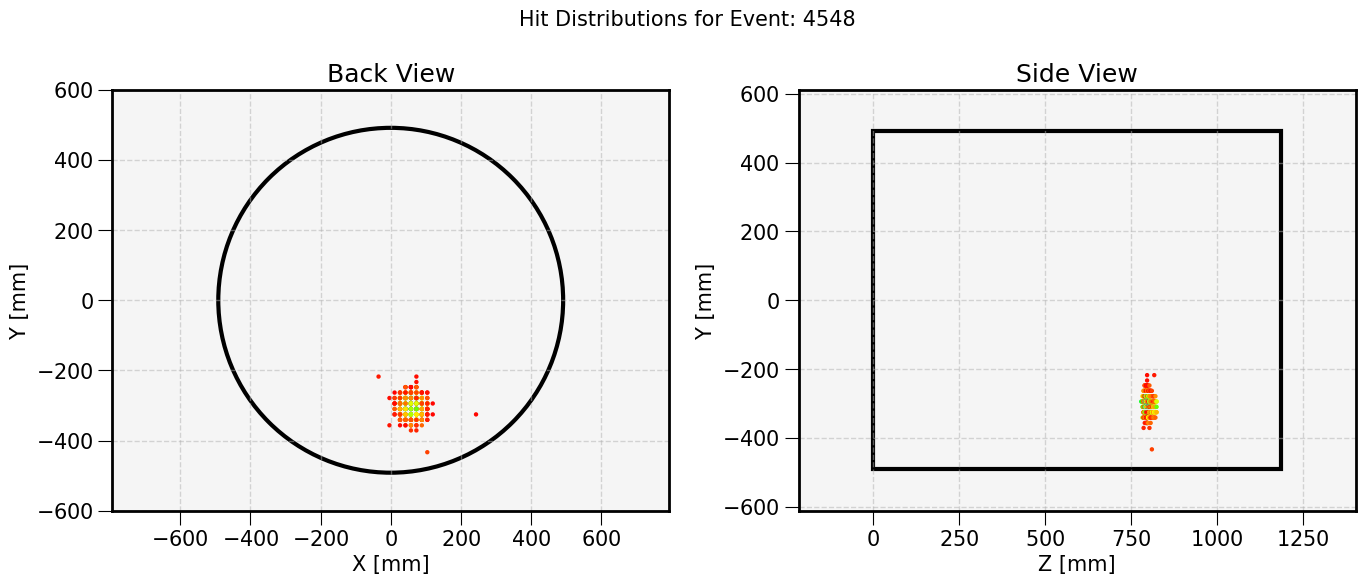

In [116]:
pt.event_display(FIDUCIAL_HITS_CATHODE_DF, variable='Ec', event_column='global_event')

In [125]:
fiducial_clusters_tagger = crudo.hits_clusterizer(eps=2.3, min_samples=5, event_column='global_event')
FIDUCIAL_HITS_CATHODE_DF = fiducial_clusters_tagger(FIDUCIAL_HITS_CATHODE_DF)

In [131]:
clust = FIDUCIAL_HITS_CATHODE_DF.groupby('global_event')['cluster']
print(clust)

In [ ]:
# Filter events where all clusters are labeled as 0
fiducial_events_with_cluster_0 = (
                                        FIDUCIAL_HITS_CATHODE_DF.groupby('global_event')['cluster']
                                        .apply(lambda clusters: (clusters == 0).all())
                                 )
# Get the global event IDs that have all clusters labeled as 0
events_ids_with_clusters_0 = fiducial_events_with_cluster_0[fiducial_events_with_cluster_0].index

In [132]:
fiducial_events_with_cluster_0

global_event
488      False
868      False
1279     False
1401      True
1862      True
         ...  
88563     True
90629    False
91424    False
92455    False
93398    False
Name: cluster, Length: 98, dtype: bool

In [129]:


# Obtener los global_event que cumplen la condición
global_events_with_cluster_0 = fiducial_events_with_cluster_0[fiducial_events_with_cluster_0].index

# Mostrar los global_event
global_events_with_cluster_0

Int64Index([ 1401,  1862,  3171,  4291, 15360, 19864, 20535, 23159, 25125,
            26203, 31302, 31661, 38603, 42930, 44258, 59837, 63145, 71557,
            73366, 73493, 74603, 75853, 78142, 78926, 82541, 83451, 86901,
            88563],
           dtype='int64', name='global_event')

In [126]:
FIDUCIAL_HITS_CATHODE_DF

,event,time,npeak,X,Xpeak,Y,Z,Q,Ec,Isotope,Volume,global_event,region,cluster
115947,2122,4.244805e+09,1,-3.575,-0.590619,-170.925,1029.465563,6.608696,0.002693,Bi214,CATHODE_SURF,488,fiducial,0
115948,2122,4.244805e+09,1,26.525,-0.590619,-247.675,1029.465563,6.724638,0.002788,Bi214,CATHODE_SURF,488,fiducial,0
115949,2122,4.244805e+09,1,10.975,-0.590619,-233.125,1029.465563,8.753623,0.003616,Bi214,CATHODE_SURF,488,fiducial,0
115950,2122,4.244805e+09,1,26.525,-0.590619,-233.125,1029.465563,9.449275,0.003909,Bi214,CATHODE_SURF,488,fiducial,0
115951,2122,4.244805e+09,1,26.525,-0.590619,-217.575,1029.465563,9.797101,0.004022,Bi214,CATHODE_SURF,488,fiducial,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23935661,384386,7.687721e+11,0,26.525,92.748455,214.825,642.783786,7.884058,0.003735,Bi214,CATHODE_SURF,93398,fiducial,0
23935662,384386,7.687721e+11,0,26.525,92.748455,230.375,642.783786,6.898551,0.003286,Bi214,CATHODE_SURF,93398,fiducial,0
23935663,384386,7.687721e+11,0,42.075,92.748455,214.825,642.783786,5.855072,0.002763,Bi214,CATHODE_SURF,93398,fiducial,0
23935664,384386,7.687721e+11,0,42.075,92.748455,214.825,646.018119,5.043478,0.003099,Bi214,CATHODE_SURF,93398,fiducial,0


In [120]:
TEST_DF.cluster.value_counts()

 0    44748
 1     1938
 2      688
-1      148
Name: cluster, dtype: int64

In [111]:
FIDUCIAL_HITS_CATHODE_DF

<function libs.crudo.hits_clusterizer.<locals>.cluster_tagger(df_hits: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

Extra information

In [32]:
GENERATED_EVTS = 385000      # If Total_gen is not available, take a look at Bi_MC_Effs.txt
INCLUSIVE_EVTS = selected_mc_df['Electron']['Inclusive']['global_event'].nunique()
FIDUCIAL_EVTS  = selected_mc_df['Electron']['Fiducial']['global_event'].nunique()
TUBE_EVTS      = selected_mc_df['Electron']['Tube']['global_event'].nunique()
ANODE_EVTS     = selected_mc_df['Electron']['Anode']['global_event'].nunique()
CATHODE_EVTS   = selected_mc_df['Electron']['Cathode']['global_event'].nunique()

# ----- Fiducial Rate ----- #
fidu_CV, fidu_var = scipy.stats.binom.stats(n=GENERATED_EVTS, p=FIDUCIAL_EVTS/GENERATED_EVTS, moments='mv')
# Fiducial rate + error for each run
RATE_CV  = fidu_CV / selected_mc_df['Run_time']            # in [Hz]
RATE_ERR = np.sqrt(fidu_var) / selected_mc_df['Run_time']  # in [Hz]

# ----- Final Verbosity ----- #
print(f"--- Classification Results ---")
print(f"Fiducial: ({FIDUCIAL_EVTS} ± {np.sqrt(fidu_var):.0f}) events ({FIDUCIAL_EVTS/INCLUSIVE_EVTS:.2%}) || Rate = ({RATE_CV*1e3:.4f} ± {RATE_ERR*1e3:.4f}) mHz")
print(f"Tube:     {TUBE_EVTS} events ({TUBE_EVTS/INCLUSIVE_EVTS:.2%})")
print(f"Anode:    {ANODE_EVTS} events ({ANODE_EVTS/INCLUSIVE_EVTS:.2%})")        
print(f"Cathode:  {CATHODE_EVTS} events ({CATHODE_EVTS/INCLUSIVE_EVTS:.2%})")

--- Classification Results ---
Fiducial: (98 ± 10) events (0.23%) || Rate = (0.3108 ± 0.0314) mHz
Tube:     168 events (0.40%)
Anode:    2460 events (5.82%)
Cathode:  39562 events (93.55%)


# Plots

In [33]:
REGIONS = ['Inclusive', 'Fiducial', 'Tube', 'Anode', 'Cathode']

## Z Distribution

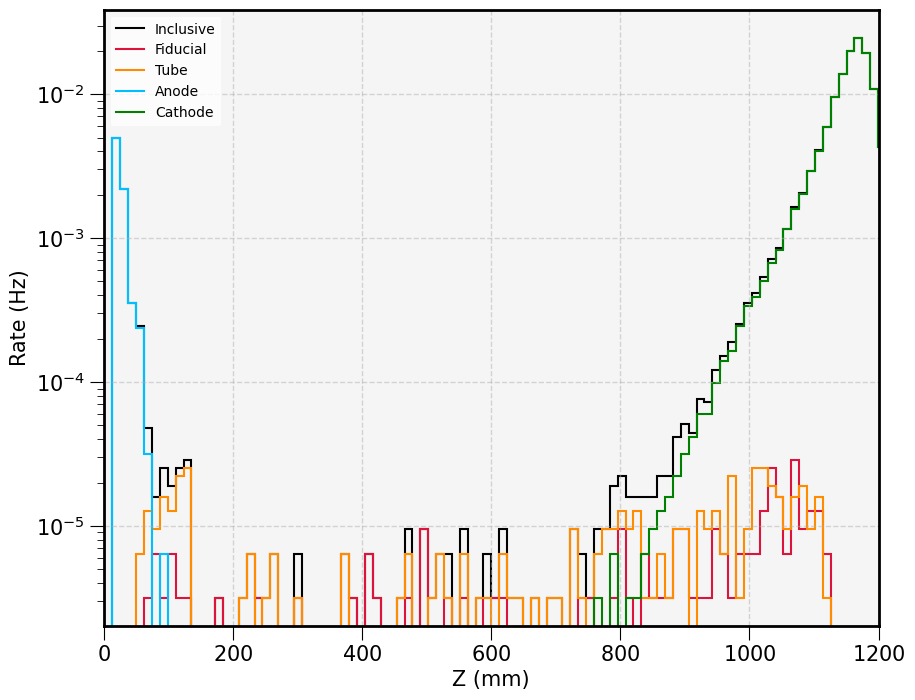

In [34]:
# Global
n_bins = 100

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, Z_edges = np.histogram(mc_all['Z'], bins=n_bins)

for i, region in enumerate(REGIONS):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    Z = mc_region['Z']

    # Histogram
    Z_counts, _ = np.histogram(Z, bins=Z_edges)
    Z_rate = Z_counts / selected_mc_df['Run_time']

    # ----- Plotting ----- #
    plt.stairs(Z_rate, Z_edges, label=region, 
               fill=False, lw=1.5, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# ----- Styling ----- #
plt.xlabel('Z (mm)')
plt.xlim(0, 1200)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=10)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## E Distribution

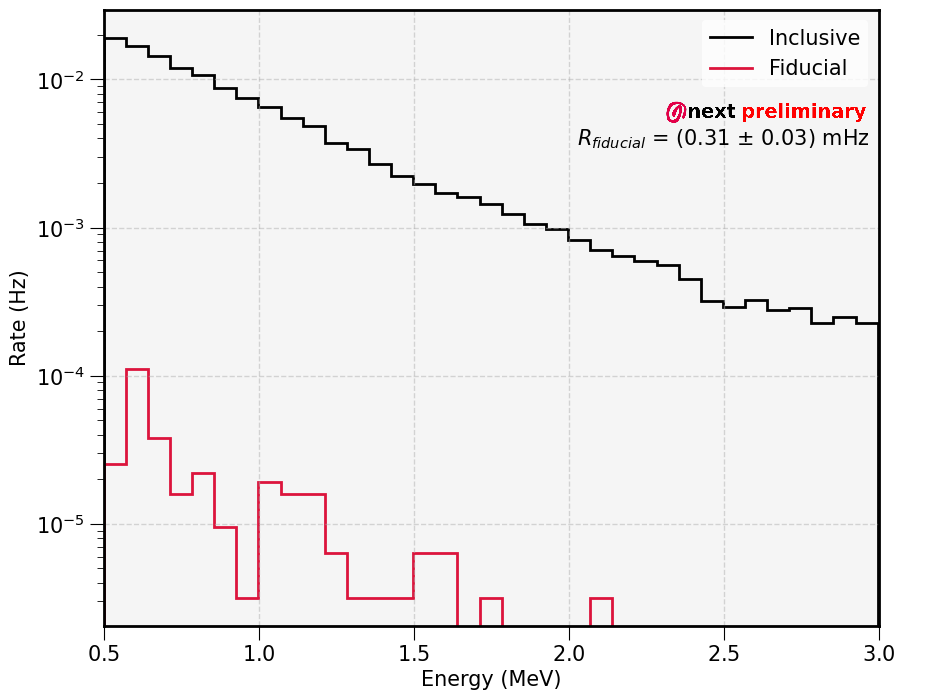

In [35]:
# Global
n_bins = 35

fig, ax = plt.subplots()

# ----- Define the Binning ----- #
# Use the "Inclusive" region to define the binning
mc_all = selected_mc_df['Electron']['Inclusive']
_, E_edges = np.histogram(mc_all['E_corr'], bins=n_bins)

for i, region in enumerate(['Inclusive', 'Fiducial']):

    # Dataframe
    mc_region = selected_mc_df['Electron'][region]

    # Variables
    E = mc_region['E_corr']

    # Histogram
    E_counts, _ = np.histogram(E, bins=E_edges)
    E_rate = E_counts / selected_mc_df['Run_time']

    # ----- Plotting ----- #
    plt.stairs(E_rate, E_edges, label=region, 
               fill=False, ec=pt.hist_colors[i % len(pt.hist_colors)], lw=2.0)
    
# plt.axvline(x=1.59, c='grey', ls='--', lw=1.0)        # DEP
    
# ----- Styling ----- #
# Important text
plt.text(2.50, 4e-3, r'$R_{fiducial}$'f' = ({RATE_CV*1e3:.2f} ± {RATE_ERR*1e3:.2f}) mHz', va='center', ha='center')

# Preliminary logo
LOGO_BOX    = OffsetImage(PRELIM_LOGO, zoom = 0.1)
xy = (2.65, 6e-3)
ab = AnnotationBbox(LOGO_BOX, xy, xybox=(0, 0), xycoords='data', boxcoords="offset points",  frameon=False)
ax.add_artist(ab)

plt.xlabel('Energy (MeV)')
plt.xlim(TRG2_THRESHOLD, ENERGY_THRESHOLD)
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.legend()

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.savefig(f'/lhome/ific/c/ccortesp/Analysis/NEXT-100/Rn_analysis/images/Bi_Fiducial.pdf')
plt.show()

# ROI Analysis

In [60]:
# ROI definition
ROI_MIN = 2.4; ROI_MAX = 2.5    # in [MeV]

# Fiducial dataframe
Fiducial_df = selected_mc_df['Electron']['Fiducial']

# Events in the ROI
ROI_mask = (Fiducial_df['E_corr'] >= ROI_MIN) & (Fiducial_df['E_corr'] <= ROI_MAX)
ROI_ids  = Fiducial_df.loc[ROI_mask, 'global_event'].unique()
print(f"Found {len(ROI_ids)} events in the ROI [{ROI_MIN}, {ROI_MAX}] MeV")

# Rate in the ROI
evts_CV, evts_var = scipy.stats.binom.stats(n=GENERATED_EVTS, p=len(ROI_ids)/GENERATED_EVTS, moments='mv')
print(f"Events in the ROI = ({int(evts_CV)} ± {np.sqrt(evts_var):.0f}) events")

ROI_rate_CV = evts_CV / selected_mc_df['Run_time']            # in [Hz]
ROI_err_CV  = np.sqrt(evts_var) / selected_mc_df['Run_time']  # in [Hz]
print(f"Rate in the ROI = ({ROI_rate_CV} ± {ROI_err_CV}) Hz")

Found 23 events in the ROI [2.4, 2.5] MeV
Events in the ROI = (23 ± 5) events
Rate in the ROI = (7.293252156265855e-08 ± 1.5207027743095953e-08) Hz


### Fiducial Mass

In [59]:
volume_fid_CV, _ = pt.selection_volume(Z_UP - Z_LOW, 1, R_UP, 1)            # in mm3 - DO NOT USE THIS ERROR
volume_fid_CV /= 1e9                                                        # in m3
temp     = 293.15       # in K
pressure = 3.95         # in bar
R_gas    = 8.3145e-5    # in m3·bar/(K·mol)

# Use PV = nRT to calculate the number of moles
n_moles = (pressure * volume_fid_CV) / (R_gas * temp)    # in mol
print(f"Fiducial - number of moles = {n_moles} mol")
# Xenon molar mass
molar_mass_Xe = 135.9072    # in g/mol
mass_fid_CV = n_moles * molar_mass_Xe / 1e3    # in kg
print(f"Fiducial - mass = {mass_fid_CV} kg")

Fiducial - number of moles = 114.9668367548998 mol
Fiducial - mass = 15.624820876215518 kg
